## Imports

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from bitcoin_deep_learning.call_api import ApiCall
from bitcoin_deep_learning.model import RnnDlModel, LinearRegressionBaselineModel, DummyModel
from bitcoin_deep_learning.trainer import train, read_result
from bitcoin_deep_learning.cross_val import get_cross_XY
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from random import random
import joblib
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Getting data

In [19]:
train_df = ApiCall().read_local(data='train')#.drop(columns = '[%]_Bitcoin_growth_rate_on_Horizon=7')

In [20]:
X_train_list, Y_train_list, X_test_list,Y_test_list = get_cross_XY()

In [21]:
np.array(X_train_list).shape

(32, 263, 90, 32)

In [22]:
train_df.head(3)

,date,[AVG]_[NH]_mean_hash_rate,[+]_[NH]_Days_Till_Halving,[//]_[AV]_Stock-to-Flow_Ratio,[+]_[NH]_Circulating_Supply,[+]_[NH]_Issuance,[+]_[NH]_Number_of_Active_Addresses,[+]_[NH]_Mean_Block_Interval,[+]_[NH]_Number_of_Transactions,[+]_[NH]_Number_of_Addresses_with_a_Non-Zero_Balance,...,[//]_[AV]_Realized_Profits-to-Value_(RPV)_Ratio,fear_greed_value,[+]_[NH]_Number_of_Addresses_with_Balance_0.01 - 0.1,[+]_[NH]_Number_of_Addresses_with_Balance_0.1 - 1,[+]_[NH]_Number_of_Addresses_with_Balance_1 - 10,[+]_[NH]_Number_of_Addresses_with_Balance_10 - 100,[+]_[NH]_Number_of_Addresses_with_Balance_100 - 1k,[+]_[NH]_Number_of_Addresses_with_Balance_1k - 10k,[+]_[T]_Bitcoin_Price,[%]_Bitcoin_growth_rate_on_Horizon=7
0,2018-02-01,2.054109e+19,830,5642.903220,16839700.0,2000.0,842398,377,257504,27026398,...,0.003691,30,4226306,1722331,544769,132314,15779,1529,9014.026207,-0.235616
1,2018-02-02,2.170824e+19,829,5641.695528,16841800.0,2100.0,854253,385,235750,26955617,...,0.002557,15,4198274,1704275,543489,132213,15815,1521,8799.121911,-0.260491
2,2018-02-03,2.073919e+19,828,5641.015128,16843775.0,1975.0,714655,384,194733,26886977,...,0.001970,40,4173275,1692828,542447,132021,15812,1523,9208.459919,-0.230759


## Data viz exploration

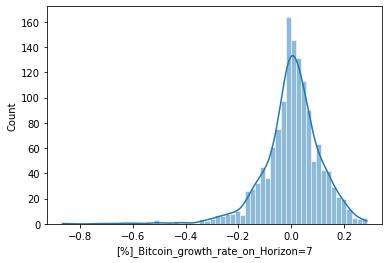

In [23]:
sns.histplot(train_df['[%]_Bitcoin_growth_rate_on_Horizon=7'], kde=True, edgecolor='w');

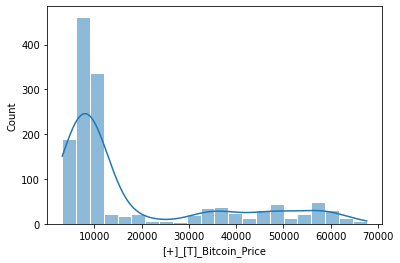

In [24]:
sns.histplot(train_df['[+]_[T]_Bitcoin_Price'], kde=True, edgecolor='w');

## Ploting models

### Plotting prediction per folds

In [25]:
def plot_predictions_models_all_folds(X_train_list, Y_train_list, X_test_list, Y_test_list, model):
    fig, axs = plt.subplots(nrows = len(X_train_list), ncols = 2, figsize = (17,150))
    for k in range(len(X_train_list)):
        X_train, y_train, X_test, y_test = X_train_list[k], Y_train_list[k], X_test_list[k], Y_test_list[k]
        #intuition too much regularization on the lasso
        model.set_model()
        model.fit(model.preproc(X_test, X_train)[1], y_train)
        y_pred = model.run(X_test, X_train, y_train)
        axs[k, 0].plot(y_test, label = 'test')
        axs[k, 0].plot(y_pred, color = 'r', label = 'pred')
        axs[k, 0].set_title('Fitting of y_test, y_pred')
        axs[k, 0].legend()
        axs[k, 1].plot(y_train, label = 'train')
        axs[k, 1].set_title('Evolution of the y_train')
        axs[k, 1].legend();

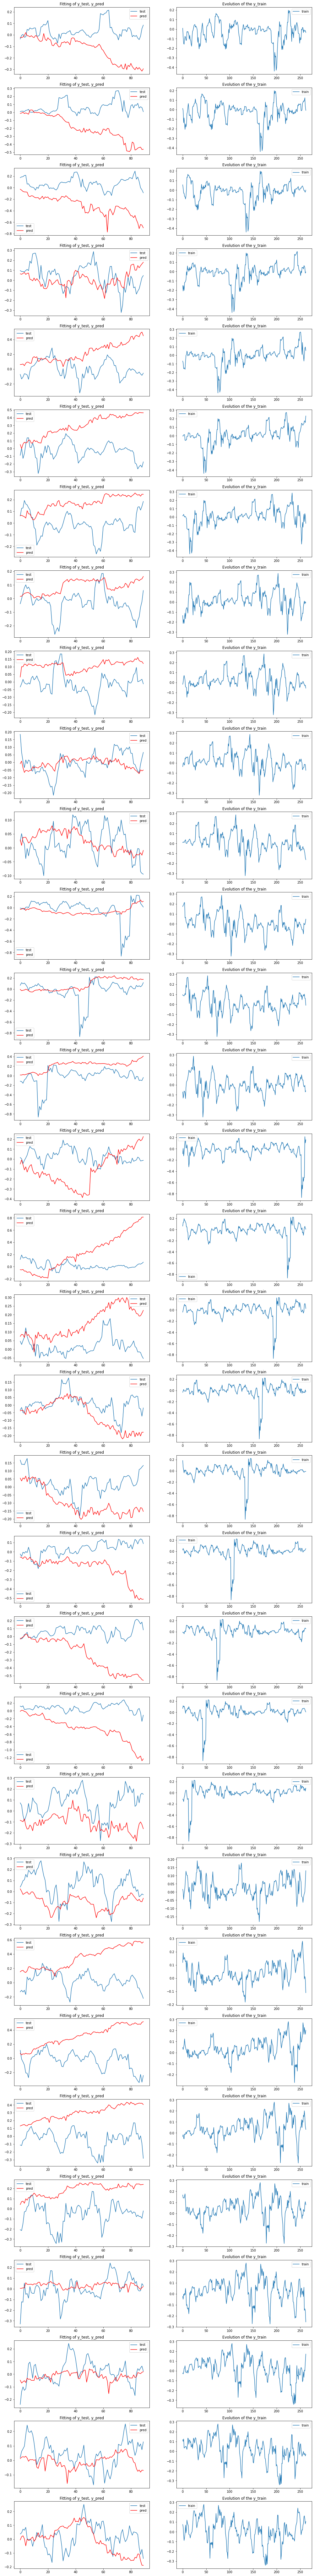

In [38]:
plot_predictions_models_all_folds(X_train_list, Y_train_list, X_test_list, Y_test_list, LinearRegressionBaselineModel(alpha = 0.008 , l1_ratio = 0.0005))

## Analysing Coefs

### Elastic Net training

In [27]:
model_regression = LinearRegressionBaselineModel(alpha = 0.01 , l1_ratio = 0.001)
train(model_regression, train_df)
model_regression.model.coef_

100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 13.93it/s]

Training done


array([-0.02700587, -0.02545379, -0.11562652,  0.01792744,  0.02716201,
       -0.07667918, -0.04277892,  0.01168218,  0.01718915, -0.10093657,
       -0.04463744, -0.01987374, -0.06568812,  0.01423925, -0.0544017 ,
       -0.08884506,  0.03140889, -0.05237216, -0.09250752, -0.08274751,
       -0.04428104,  0.01178514,  0.00774667, -0.00370479,  0.03593648,
        0.01435675,  0.12051628,  0.04723806, -0.07914889,  0.01859832,
       -0.13595689])

In [28]:
train_df_matrix = train_df.copy().drop(columns = 'date')
len(train_df_matrix.columns)

32

In [29]:
coeff_matrix = pd.DataFrame(zip(train_df_matrix.columns,model_regression.model.coef_))
coeff_matrix = coeff_matrix.rename(columns={0: "features", 1: "coeff"})
coeff_matrix_absolute = coeff_matrix.copy()
coeff_matrix_absolute['coeff abs'] = coeff_matrix['coeff'].apply(abs)
coeff_matrix_absolute = coeff_matrix_absolute.drop(columns = 'coeff')
coeff_matrix_absolute.sort_values(by = 'coeff abs', ascending = False).reset_index(drop = True)

,features,coeff abs
0,[+]_[T]_Bitcoin_Price,0.135957
1,[+]_[NH]_Number_of_Addresses_with_Balance_1 - 10,0.120516
2,[//]_[AV]_Stock-to-Flow_Ratio,0.115627
3,[+]_[NH]_Number_of_Addresses_with_Balance_≥_10k,0.100937
4,[$]_[BSB]_Realized_Price,0.092508
5,[$]_[BSB]_Exchange_Net_Position_Change_-_All_E...,0.088845
6,[%]_[BSB]_Price_Drawdown_from_ATH,0.082748
7,[+]_[NH]_Number_of_Addresses_with_Balance_100 ...,0.079149
8,[+]_[NH]_Number_of_Active_Addresses,0.076679
9,[AVG]_[BSB]_Average_Spent_Output_Lifespan_(ASOL),0.065688


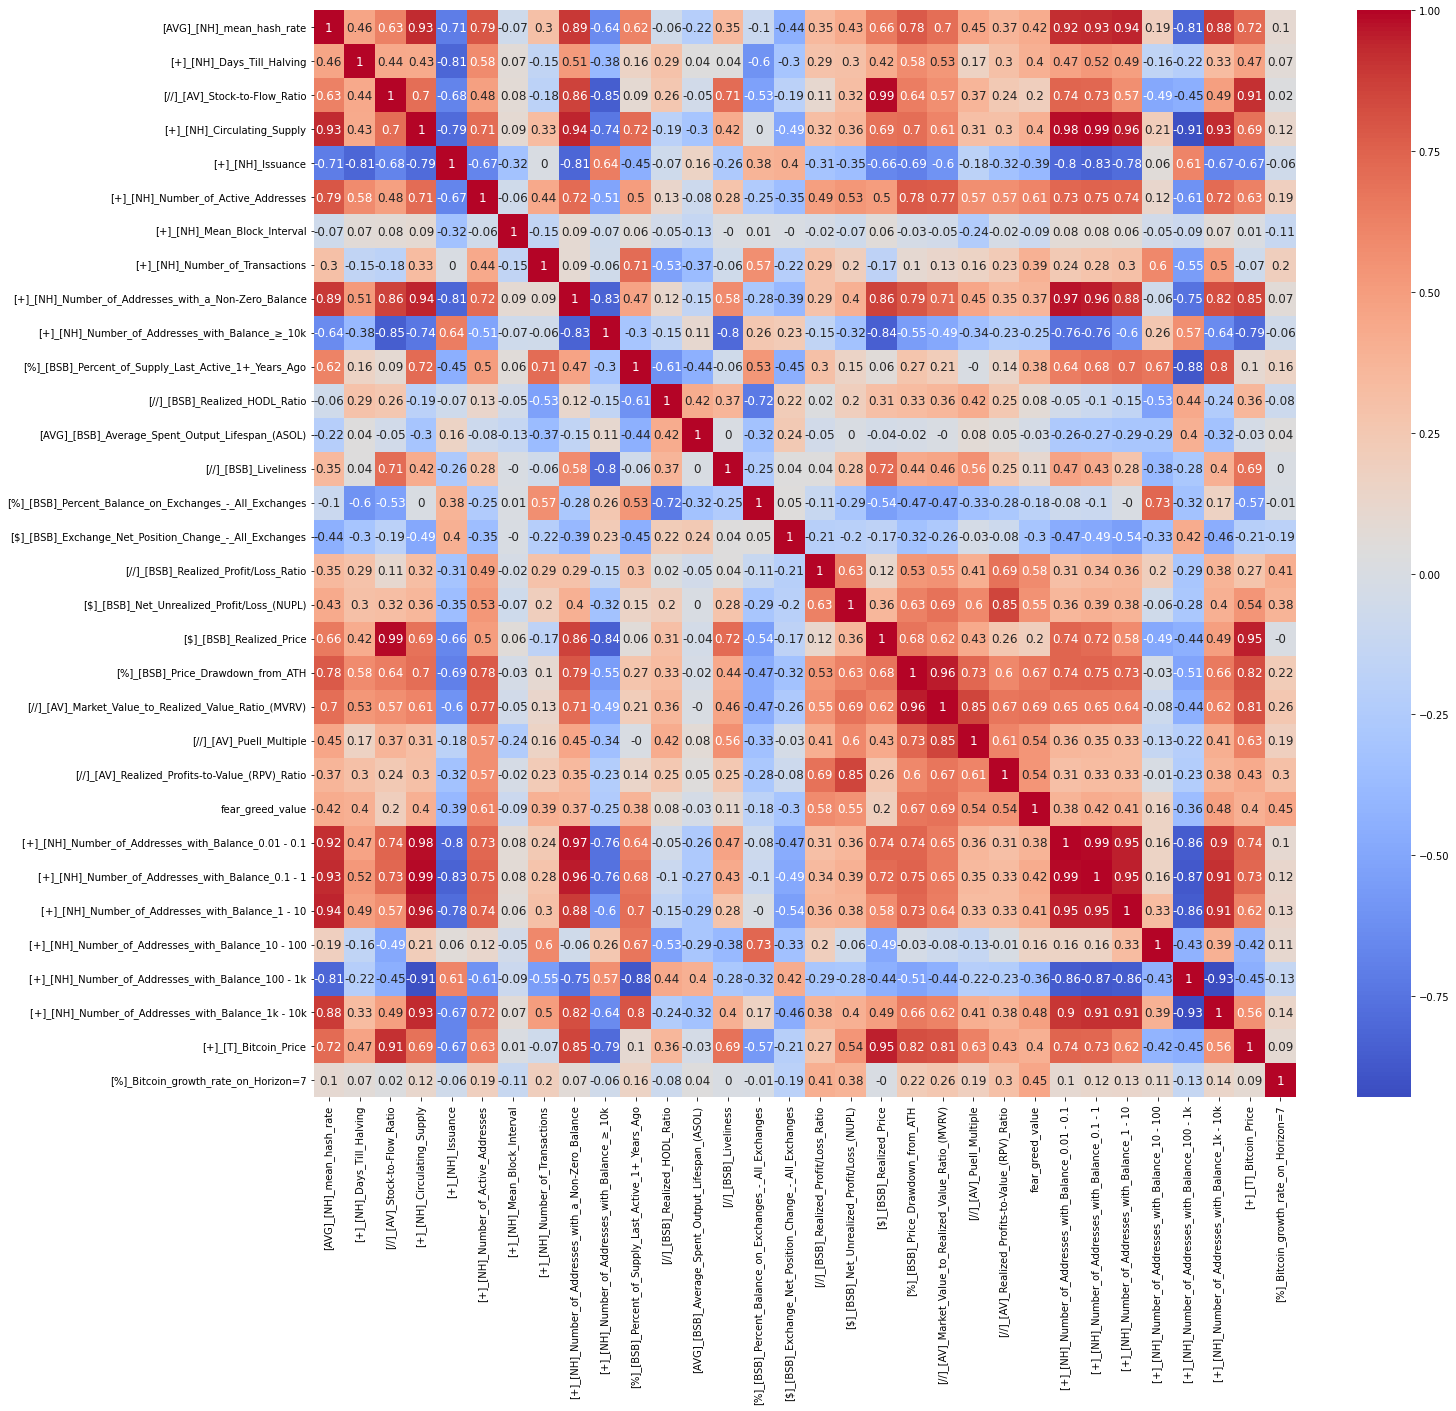

In [30]:
plt.figure(figsize = (22,20))
sns.heatmap(round(train_df_matrix.corr(),2), cmap = "coolwarm", annot = True, annot_kws = {"size":12});

In [31]:
train_df_matrix.corr().style.background_gradient(cmap='coolwarm')

,[AVG]_[NH]_mean_hash_rate,[+]_[NH]_Days_Till_Halving,[//]_[AV]_Stock-to-Flow_Ratio,[+]_[NH]_Circulating_Supply,[+]_[NH]_Issuance,[+]_[NH]_Number_of_Active_Addresses,[+]_[NH]_Mean_Block_Interval,[+]_[NH]_Number_of_Transactions,[+]_[NH]_Number_of_Addresses_with_a_Non-Zero_Balance,[+]_[NH]_Number_of_Addresses_with_Balance_≥_10k,[%]_[BSB]_Percent_of_Supply_Last_Active_1+_Years_Ago,[//]_[BSB]_Realized_HODL_Ratio,[AVG]_[BSB]_Average_Spent_Output_Lifespan_(ASOL),[//]_[BSB]_Liveliness,[%]_[BSB]_Percent_Balance_on_Exchanges_-_All_Exchanges,[$]_[BSB]_Exchange_Net_Position_Change_-_All_Exchanges,[//]_[BSB]_Realized_Profit/Loss_Ratio,[$]_[BSB]_Net_Unrealized_Profit/Loss_(NUPL),[$]_[BSB]_Realized_Price,[%]_[BSB]_Price_Drawdown_from_ATH,[//]_[AV]_Market_Value_to_Realized_Value_Ratio_(MVRV),[//]_[AV]_Puell_Multiple,[//]_[AV]_Realized_Profits-to-Value_(RPV)_Ratio,fear_greed_value,[+]_[NH]_Number_of_Addresses_with_Balance_0.01 - 0.1,[+]_[NH]_Number_of_Addresses_with_Balance_0.1 - 1,[+]_[NH]_Number_of_Addresses_with_Balance_1 - 10,[+]_[NH]_Number_of_Addresses_with_Balance_10 - 100,[+]_[NH]_Number_of_Addresses_with_Balance_100 - 1k,[+]_[NH]_Number_of_Addresses_with_Balance_1k - 10k,[+]_[T]_Bitcoin_Price,[%]_Bitcoin_growth_rate_on_Horizon=7
[AVG]_[NH]_mean_hash_rate,1.000000,0.463162,0.630272,0.927254,-0.713023,0.786381,-0.073801,0.301860,0.891833,-0.643322,0.618119,-0.063496,-0.223503,0.347550,-0.101402,-0.437090,0.352117,0.431304,0.659304,0.780823,0.701315,0.454142,0.365043,0.423765,0.918904,0.930719,0.943290,0.194657,-0.805036,0.875091,0.720093,0.099333
[+]_[NH]_Days_Till_Halving,0.463162,1.000000,0.436686,0.429657,-0.805983,0.578631,0.065331,-0.149927,0.508994,-0.375368,0.157318,0.289766,0.043285,0.036267,-0.600147,-0.301794,0.293104,0.304748,0.421554,0.576468,0.527815,0.167947,0.304031,0.400049,0.468325,0.524134,0.490902,-0.162074,-0.221128,0.328114,0.468869,0.071926
[//]_[AV]_Stock-to-Flow_Ratio,0.630272,0.436686,1.000000,0.699625,-0.677524,0.480806,0.080088,-0.175301,0.862580,-0.854968,0.093267,0.264620,-0.049654,0.707004,-0.527314,-0.189448,0.111482,0.316725,0.987622,0.641979,0.567133,0.371118,0.237082,0.197502,0.741116,0.729136,0.567840,-0.491804,-0.454631,0.488282,0.907228,0.016407
[+]_[NH]_Circulating_Supply,0.927254,0.429657,0.699625,1.000000,-0.786063,0.714104,0.086624,0.326221,0.937293,-0.743304,0.722398,-0.186994,-0.300755,0.417440,0.001863,-0.487898,0.321092,0.364316,0.692872,0.700965,0.606103,0.311283,0.303428,0.395860,0.983193,0.988826,0.956484,0.213059,-0.910020,0.927786,0.692906,0.116837
[+]_[NH]_Issuance,-0.713023,-0.805983,-0.677524,-0.786063,1.000000,-0.668086,-0.320479,0.001770,-0.812060,0.642768,-0.448694,-0.071819,0.158712,-0.264509,0.377007,0.403575,-0.307451,-0.348981,-0.661812,-0.685705,-0.601294,-0.176091,-0.321128,-0.394968,-0.796507,-0.833646,-0.777212,0.063212,0.611146,-0.672511,-0.668621,-0.056325
[+]_[NH]_Number_of_Active_Addresses,0.786381,0.578631,0.480806,0.714104,-0.668086,1.000000,-0.056700,0.435906,0.721946,-0.508453,0.502838,0.127929,-0.076097,0.278546,-0.250836,-0.352549,0.489958,0.530693,0.502424,0.777987,0.767602,0.568191,0.568599,0.607500,0.727705,0.752795,0.742836,0.117266,-0.605357,0.724242,0.630793,0.188191
[+]_[NH]_Mean_Block_Interval,-0.073801,0.065331,0.080088,0.086624,-0.320479,-0.056700,1.000000,-0.151175,0.086287,-0.065396,0.060285,-0.048750,-0.127808,-0.002316,0.006697,-0.004033,-0.022181,-0.070075,0.062311,-0.031664,-0.048209,-0.236837,-0.023801,-0.088799,0.081083,0.082681,0.063204,-0.053364,-0.085416,0.067555,0.013641,-0.111179
[+]_[NH]_Number_of_Transactions,0.301860,-0.149927,-0.175301,0.326221,0.001770,0.435906,-0.151175,1.000000,0.094885,-0.061054,0.710053,-0.530574,-0.369062,-0.064793,0.573083,-0.216057,0.286628,0.204785,-0.173141,0.100348,0.127519,0.161841,0.231085,0.391686,0.242221,0.277518,0.299925,0.597508,-0.553054,0.500125,-0.067680,0.198020
[+]_[NH]_Number_of_Addresses_with_a_Non-Zero_Balance,0.891833,0.508994,0.862580,0.937293,-0.812060,0.721946,0.086287,0.094885,1.000000,-0.

### VIF index

In [32]:
train_df_nodates = train_df.copy().drop(columns = 'date')#.drop(columns = bucket_list)

In [33]:
train_df_nodates_scaled = train_df_nodates.copy()

for feature in train_df_nodates_scaled.columns:
    mu = train_df_nodates[feature].mean()
    sigma = train_df_nodates[feature].std()
    train_df_nodates_scaled[feature] = train_df_nodates_scaled[feature].apply(lambda x: (x-mu)/sigma)

In [34]:
df = pd.DataFrame()

df["features"] = train_df_nodates_scaled.columns

df["vif_index"] = [vif(train_df_nodates_scaled.values, i) for i in range(train_df_nodates_scaled.shape[1])]

round(df.sort_values(by="vif_index", ascending = False),2).reset_index(drop = True)

,features,vif_index
0,[+]_[NH]_Circulating_Supply,541.09
1,[$]_[BSB]_Realized_Price,457.67
2,[//]_[AV]_Stock-to-Flow_Ratio,290.22
3,[+]_[NH]_Number_of_Addresses_with_Balance_0.01...,276.45
4,[+]_[NH]_Number_of_Addresses_with_a_Non-Zero_B...,257.74
5,[+]_[NH]_Number_of_Addresses_with_Balance_0.1 - 1,237.33
6,[+]_[T]_Bitcoin_Price,172.11
7,[//]_[AV]_Market_Value_to_Realized_Value_Ratio...,163.09
8,[+]_[NH]_Number_of_Addresses_with_Balance_1 - 10,100.08
9,[%]_[BSB]_Price_Drawdown_from_ATH,79.25


## Grid search and training

### Dummy model instanciating

In [36]:
# Instanciate model
dummy_model = DummyModel()
# Train and Fit data using the crossval
train(dummy_model,train_df);

100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 14.55it/s]

Training done


### Elastic Net Tuning

In [94]:
# Instanciate Grid Search
for counter in range(20):
    alpha = 0.1 * random()
    l1 = 0.001
    # Instanciate model
    regression_model = LinearRegressionBaselineModel(alpha = alpha, l1_ratio = l1)
    # Train and Fit data using the crossval
    train(regression_model,train_df);

100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 14.63it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 14.33it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 14.52it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 14.53it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 14.58it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 14.52it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 14.37it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 14.58it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 14.45it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 13.86it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 14.25it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 14.44it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 14.50it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 14.51it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 14.33it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 14.60it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 14.55it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 14.48it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 14.65it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 14.68it/s]

Training done


### RNN Tuning

In [ ]:
# Instanciate Grid Search
for counter in range(10):
    l1_rnn = random() / 10
    l2_rnn = random() / 10
    # Instanciate model
    rnn_model = RnnDlModel(L1 = l1_rnn, L2 = l2_rnn, epochs = 2, patience = 10)
    # Train and Fit data using the crossval
    fold_score, score = train(rnn_model,train_df);

## Exporting and viewing results

In [37]:
df_result = read_result()
df_result.sort_values(by="mean_score", ascending = True)

,name,fold_score,mean_score,min_score,max_score,hyperparams,date
14,LinearReg,"[0.08783, 0.11867, 0.15012, 0.09501, 0.13382, ...",0.11129,0.03623,0.27049,"{'alpha': 0.09826776612681243, 'l1_ratio': 0.001}",08-03 16:33:51
7,LinearReg,"[0.08827, 0.1195, 0.15139, 0.09508, 0.13436, 0...",0.11175,0.03612,0.27305,"{'alpha': 0.096015433358184, 'l1_ratio': 0.001}",08-03 16:33:36
3,LinearReg,"[0.08834, 0.11963, 0.15158, 0.09509, 0.13444, ...",0.11182,0.03611,0.27343,"{'alpha': 0.09568340978150307, 'l1_ratio': 0.001}",08-03 16:33:27
9,LinearReg,"[0.08854, 0.11999, 0.15214, 0.09513, 0.13467, ...",0.11202,0.03606,0.27454,"{'alpha': 0.09472253193196829, 'l1_ratio': 0.001}",08-03 16:33:40
5,LinearReg,"[0.08935, 0.12152, 0.15446, 0.09527, 0.13563, ...",0.11284,0.03584,0.27915,"{'alpha': 0.09087247226607797, 'l1_ratio': 0.001}",08-03 16:33:31
8,LinearReg,"[0.09024, 0.12321, 0.15703, 0.09543, 0.13669, ...",0.11374,0.03557,0.28419,"{'alpha': 0.08686480771192921, 'l1_ratio': 0.001}",08-03 16:33:38
20,LinearReg,"[0.09066, 0.12404, 0.15828, 0.09552, 0.13722, ...",0.11417,0.03543,0.28663,"{'alpha': 0.08500447175239248, 'l1_ratio': 0.001}",08-03 16:34:05
19,LinearReg,"[0.0909, 0.1245, 0.15899, 0.09558, 0.13753, 0....",0.11442,0.03535,0.28801,"{'alpha': 0.08397272066942572, 'l1_ratio': 0.001}",08-03 16:34:02
13,LinearReg,"[0.09149, 0.12564, 0.16073, 0.09572, 0.13826, ...",0.11502,0.03512,0.29135,"{'alpha': 0.08153383362510946, 'l1_ratio': 0.001}",08-03 16:33:49
6,LinearReg,"[0.09247, 0.12755, 0.16362, 0.09596, 0.13949, ...",0.11603,0.03472,0.29687,"{'alpha': 0.07767447353148066, 'l1_ratio': 0.001}",08-03 16:33:34


## (Optionnal) Plotting scores on cross validated models

In [49]:
# Instanciate Grid Search
scores_regression = []
scores_baseline = []
scores_rnn = []
for counter in range(10):
    alpha = 50 * random()
    l1 = 0.001
    # Instanciate model
    regression_model = LinearRegressionBaselineModel(alpha = alpha, l1_ratio = l1)
    # Train and Fit data using the crossval
    fold_score, score = train(regression_model,train_df)
    scores.append(score)
    # Instanciate model
    dummy_model = DummyModel()
    # Train and Fit data using the crossval
    train(dummy_model,train_df)
    l1_rnn = random() / 10
    l2_rnn = random() / 10
    # Instanciate model
    rnn_model = RnnDlModel(L1 = l1_rnn, L2 = l2_rnn, epochs = 2, patience = 10)
    # Train and Fit data using the crossval
    fold_score, score = train(rnn_model,train_df)

#Plotting
plt.plot(scores_regression, color = 'r', label = 'regression')
plt.plot(scores_baseline, color = 'b', label = 'last value')
plt.plot(scores_rnn, color = 'g', label = 'rnn')
plt.legend()
plt.title('Model scores comparison chart')


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 14.23it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 14.08it/s]


Training done


  0%|                                                    | 0/32 [00:00<?, ?it/s]2022-03-08 15:48:08.022330: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-08 15:48:08.263690: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2
7/7 [==============================] - 3s 119ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan             
Epoch 2/2
7/7 [==============================] - 1s 78ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan


  3%|█▍                                          | 1/32 [00:03<02:01,  3.92s/it]

Epoch 1/2
7/7 [==============================] - 3s 114ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan             
Epoch 2/2
7/7 [==============================] - 1s 74ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan


  6%|██▊                                         | 2/32 [00:07<01:53,  3.78s/it]

Epoch 1/2
7/7 [==============================] - 2s 116ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan             
Epoch 2/2
7/7 [==============================] - 1s 76ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan


  9%|████▏                                       | 3/32 [00:10<01:44,  3.59s/it]

Epoch 1/2
7/7 [==============================] - 3s 113ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan            
Epoch 2/2
7/7 [==============================] - 1s 91ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan


 12%|█████▌                                      | 4/32 [00:14<01:42,  3.65s/it]

Epoch 1/2
7/7 [==============================] - 2s 113ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan              
Epoch 2/2
7/7 [==============================] - 1s 76ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan


 16%|██████▉                                     | 5/32 [00:18<01:36,  3.56s/it]

Epoch 1/2
7/7 [==============================] - 3s 113ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan        
Epoch 2/2
7/7 [==============================] - 1s 76ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan


 19%|████████▎                                   | 6/32 [00:21<01:33,  3.59s/it]

Epoch 1/2
7/7 [==============================] - 2s 115ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan          
Epoch 2/2
7/7 [==============================] - 1s 78ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan


 22%|█████████▋                                  | 7/32 [00:25<01:28,  3.54s/it]

Epoch 1/2
7/7 [==============================] - 3s 114ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan          
Epoch 2/2
7/7 [==============================] - 1s 75ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan


 25%|███████████                                 | 8/32 [00:28<01:25,  3.58s/it]

Epoch 1/2
7/7 [==============================] - 2s 113ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan            
Epoch 2/2
7/7 [==============================] - 1s 78ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan


 28%|████████████▍                               | 9/32 [00:32<01:20,  3.52s/it]

Epoch 1/2
7/7 [==============================] - 3s 148ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan             
Epoch 2/2
7/7 [==============================] - 1s 77ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan


 31%|█████████████▍                             | 10/32 [00:36<01:20,  3.67s/it]

Epoch 1/2
7/7 [==============================] - 3s 115ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan             
Epoch 2/2
7/7 [==============================] - 1s 75ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan


 34%|██████████████▊                            | 11/32 [00:39<01:15,  3.60s/it]

Epoch 1/2
7/7 [==============================] - 3s 113ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan           
Epoch 2/2
7/7 [==============================] - 1s 81ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan


 38%|████████████████▏                          | 12/32 [00:43<01:13,  3.67s/it]

Epoch 1/2
7/7 [==============================] - 3s 148ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan             
Epoch 2/2
7/7 [==============================] - 1s 91ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan


 41%|█████████████████▍                         | 13/32 [00:47<01:13,  3.85s/it]

Epoch 1/2
7/7 [==============================] - 3s 119ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan            
Epoch 2/2
7/7 [==============================] - 1s 77ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan


 44%|██████████████████▊                        | 14/32 [00:51<01:10,  3.93s/it]

Epoch 1/2
7/7 [==============================] - 3s 112ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan             
Epoch 2/2
7/7 [==============================] - 1s 76ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan


 47%|████████████████████▏                      | 15/32 [00:55<01:04,  3.78s/it]

Epoch 1/2
7/7 [==============================] - 3s 113ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan           
Epoch 2/2
7/7 [==============================] - 1s 76ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan


 50%|█████████████████████▌                     | 16/32 [00:59<01:00,  3.75s/it]

Epoch 1/2
7/7 [==============================] - 3s 139ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan           
Epoch 2/2
7/7 [==============================] - 1s 107ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan


 53%|██████████████████████▊                    | 17/32 [01:03<00:58,  3.89s/it]

Epoch 1/2
7/7 [==============================] - 3s 114ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan         
Epoch 2/2
7/7 [==============================] - 1s 81ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan


 56%|████████████████████████▏                  | 18/32 [01:07<00:55,  3.93s/it]

Epoch 1/2
7/7 [==============================] - 3s 129ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan           
Epoch 2/2
7/7 [==============================] - 1s 80ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan


 59%|█████████████████████████▌                 | 19/32 [01:10<00:49,  3.84s/it]

Epoch 1/2
7/7 [==============================] - 3s 122ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan             
Epoch 2/2
7/7 [==============================] - 1s 76ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan


 62%|██████████████████████████▉                | 20/32 [01:14<00:46,  3.89s/it]

Epoch 1/2
7/7 [==============================] - 3s 116ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan             
Epoch 2/2
7/7 [==============================] - 1s 75ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan


 66%|████████████████████████████▏              | 21/32 [01:18<00:41,  3.77s/it]

Epoch 1/2
7/7 [==============================] - 3s 119ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan           
Epoch 2/2
7/7 [==============================] - 1s 75ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan


 69%|█████████████████████████████▌             | 22/32 [01:22<00:38,  3.80s/it]

Epoch 1/2
7/7 [==============================] - 3s 118ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan             
Epoch 2/2
7/7 [==============================] - 1s 75ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan


 72%|██████████████████████████████▉            | 23/32 [01:25<00:33,  3.71s/it]

Epoch 1/2
7/7 [==============================] - 3s 117ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan           
Epoch 2/2
7/7 [==============================] - 1s 80ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan


 75%|████████████████████████████████▎          | 24/32 [01:29<00:30,  3.75s/it]

Epoch 1/2
7/7 [==============================] - 3s 113ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan             
Epoch 2/2
7/7 [==============================] - 1s 76ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan


 78%|█████████████████████████████████▌         | 25/32 [01:33<00:25,  3.66s/it]

Epoch 1/2
7/7 [==============================] - 3s 114ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan           
Epoch 2/2
7/7 [==============================] - 1s 75ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan


 81%|██████████████████████████████████▉        | 26/32 [01:36<00:22,  3.68s/it]

Epoch 1/2
7/7 [==============================] - 3s 120ms/step - loss: 9.0261 - mape: 106.7348 - val_loss: 8.6259 - val_mape: 99.0300
Epoch 2/2
7/7 [==============================] - 1s 79ms/step - loss: 8.4154 - mape: 135.1492 - val_loss: 8.1437 - val_mape: 98.5182


 84%|████████████████████████████████████▎      | 27/32 [01:40<00:18,  3.63s/it]

Epoch 1/2
7/7 [==============================] - 3s 115ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan          
Epoch 2/2
7/7 [==============================] - 1s 76ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan


 88%|█████████████████████████████████████▋     | 28/32 [01:44<00:14,  3.65s/it]

Epoch 1/2
7/7 [==============================] - 3s 117ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan             
Epoch 2/2
7/7 [==============================] - 1s 76ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan


 91%|██████████████████████████████████████▉    | 29/32 [01:47<00:10,  3.60s/it]

Epoch 1/2
7/7 [==============================] - 3s 114ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan           
Epoch 2/2
7/7 [==============================] - 1s 76ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan


 94%|████████████████████████████████████████▎  | 30/32 [01:51<00:07,  3.69s/it]

Epoch 1/2
7/7 [==============================] - 3s 115ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan             
Epoch 2/2
7/7 [==============================] - 1s 76ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan


 97%|█████████████████████████████████████████▋ | 31/32 [01:54<00:03,  3.62s/it]

Epoch 1/2
7/7 [==============================] - 3s 115ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan
Epoch 2/2
7/7 [==============================] - 1s 78ms/step - loss: nan - mape: nan - val_loss: nan - val_mape: nan


100%|███████████████████████████████████████████| 32/32 [01:58<00:00,  3.71s/it]


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').